In [37]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [38]:
def calculateSimpleInterest(currentTotal,deltaT,apy):
    interest = currentTotal*apy/365*deltaT
    return interest

def compoundValue(currentTotal,deltaT,apy,fee):
### currentTotal in coins. deltaT in days. apy in decimal. fee in coins.
    interest = calculateSimpleInterest(currentTotal,deltaT,apy)
    newTotal =  currentTotal+interest-fee
    return newTotal


In [39]:
def simulateTime(principal,deltaT,apy,fee,timeLength):
    ### principal in coins. deltaT in days. apy in decimal. fee in coins. timeLength in years
    compoundingEvents = int(timeLength/(deltaT/365.))

    activeTotal = principal
    for event in range(1,compoundingEvents+1):
        activeTotal = compoundValue(activeTotal,deltaT,apy,fee)

    #Account for interest gained during the final part of the time frame. Assumes you pull out at the end of the year no matter what.
    fractionalEvent = timeLength/(deltaT/365)%1
    #Approximating the end of the timeframe as getting a percentage of the growth over the next deltaT. Crude because it'll overestimate for small fractions but it should work.
    activeTotal = activeTotal + fractionalEvent*calculateSimpleInterest(activeTotal,deltaT,apy)


    return activeTotal

In [40]:
vectorizedSimulateTime = np.vectorize(simulateTime)

In [41]:
#Sanity checking formulas
print("The calculated total:", simulateTime(10,365,0.1,0.0014,1))
print("The interest should be 1. It is:", calculateSimpleInterest(10,365,0.1))
print("The total should be:", 10+1-0.0014,"\n")

print("If there's no interest and no fees:",simulateTime(10,365,0,0,1))
print("If there's no fees:",simulateTime(10,365,0.1,0,1),"\n")
print("Approximately continuous with no fees:",simulateTime(10,0.001,0.1,0,1), ". Should be:", 10*np.exp(0.1*1))
print("The difference: ",simulateTime(10,0.001,0.1,0,1)-10*np.exp(0.1*1)," can be attributed to numerical error/continuous approximation error.")

The calculated total: 10.9986
The interest should be 1. It is: 1.0
The total should be: 10.9986 

If there's no interest and no fees: 10.0
If there's no fees: 11.0 

Approximately continuous with no fees: 11.051709029363042 . Should be: 11.051709180756477
The difference:  -1.5139343467751587e-07  can be attributed to numerical error/continuous approximation error.


# **EDIT THESE PARAMETERS**

In [42]:
### Maximum finding paremeters:
principal = 50
apy = 0.1
fee = 0.004   # Important to include the total fees involved in the whole process including the redelegation of the reward

timeLength=1 # Years

# The minimum deltaT is the amount of time to accumulate 1 fee's worth of a token
minimumDeltaT=fee/(principal*apy/365)

# Negating function to find the minimum
neg_simulateTime = lambda deltaT: -1*simulateTime(principal,deltaT,apy,fee,timeLength)
brent_deltaT_o = opt.minimize_scalar(neg_simulateTime,bracket=(minimumDeltaT,timeLength))
print("Optimal re-investing time:", brent_deltaT_o.x)
print("Due to approximations take this with a grain of salt. It's more useful to look at the graphs below.")

Optimal re-investing time: 45.763966147781346
Due to approximations take this with a grain of salt. It's more useful to look at the graphs below.


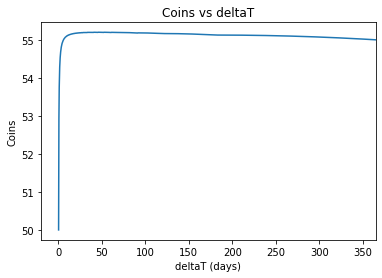

(-10.0, 200.0)

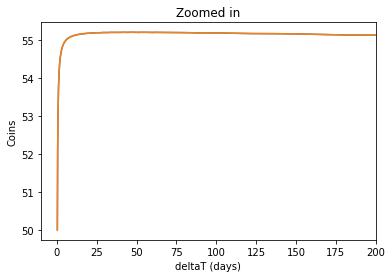

In [43]:
endpoint=timeLength*365
x = np.linspace(minimumDeltaT,endpoint,num=2000)
y = vectorizedSimulateTime(principal,x,apy,fee,timeLength)
plt.plot(x,y)
plt.xlim((-20,endpoint))
plt.title("Coins vs deltaT")
plt.xlabel("deltaT (days)")
plt.ylabel("Coins")
plt.show()

plt.plot(x,y)
plt.title("Zoomed in")
plt.xlabel("deltaT (days)")
plt.ylabel("Coins")
plt.xlim((-10,endpoint/4))

plt.plot(x,y)
plt.title("Zoomed in")
plt.xlabel("deltaT (days)")
plt.ylabel("Coins")
plt.xlim((-10,200))